# Multimodality segmentation of brain lesions in patients with Multiple Sclerosis

The goal of this project is to segment white matter lesions in patients with Multiple Sclerosis by using a custom segmentation algorithm using multimodality (MPRAGE and FLAIR). This project is part of the course WSBIM2243 given at UCLouvain in Belgium. 

The method is compared with classical method such as Otsu and Expectation-Maximization.

<img src="img/MS.png"/>

The workflow is the following and each part is detailled in the notebook 

<img src="img/pipeline.png"/>

GitHub repo : https://github.com/amanpreetsingh-BE/WSBIM2243 <br/>
Using with docker in command line type : 'docker run -it -p 8888:8888 amsingh05/wsbim2243'

## 0.1 Import dependencies

In [1]:
# Required imports (installed with Docker)
import os,sys,inspect, platform
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
sys.path.insert(1, './../utils/')

import warnings
warnings.simplefilter("ignore", FutureWarning)

from dicom2bids import *
from utils import *

from matplotlib import pyplot as plt

print("[INFO] Imports done")

[INFO] Imports done


## 0.2 Define paths

In [6]:
# Creating Output BIDS directory: INSERT YOUR OWN LOCAL PATH
try:
    os.mkdir("../../data/bids_dir")
    os.mkdir("../../data/bids_dir/derivatives")
    os.mkdir("../../data/bids_dir/derivatives/transformations")
    os.mkdir("../../data/bids_dir/derivatives/stats")
    os.mkdir("../../data/bids_dir/derivatives/samseg")
    os.mkdir("../../data/bids_dir/derivatives/segmentations")
except FileExistsError:
    print("[Exception Caught] BIDS directory already exists.")

bids_dir = "../../data/bids_dir"

# Path to dcm2niix.exe converter

if(platform.system() == 'Darwin'):
    dicom2niix_path = "../utils/dcm2niix" # for Mac users
if(platform.system() == 'Windows'):
    dicom2niix_path = "../utils/dcm2niix.exe" # for Windows users
else:
    dicom2niix_path = "../utils/dcm2niix-lnx" # for Linux users

print("[INFO] Defined paths done")

[Exception Caught] BIDS directory already exists.
[INFO] Defined paths done


## 1. Import and convert DICOM to nifti and put in BIDS format

The first step is to convert the raw DICOM files downloaded from the MRI software into an organized structure with folders and consistent naming (BIDS format (brain imaging data structure)). All utility functions are stored in the 'dicom2bids.py' file.



In [7]:
# Path to DICOM directory
directory = "D:\WSBIM\sub-019"

# Convert all DICOMs
dicom_series = convert_all_dicoms(directory, dicom2niix_path, convert=True)

# Create directories in the BIDS file structure by giving an incremental id
pat_id, session = make_directories(bids_dir,pat_id=None,session=None)
# To specify the patient id:
# pat_id, session = make_directories(bids_dir,pat_id='ID_TO_SPECIFY',session=None)
# To specify the patient id and session:
# pat_id, session = make_directories(bids_dir,pat_id='ID_TO_SPECIFY',session='SESSION_TO_SPECIFY')

# Rename and move all (interesting) converted files into the bids directory
rename_and_move_nifti(dicom_series, bids_dir, pat_id, session)

print(f"[INFO] ID {pat_id} was given to this subject")
print("[INFO] Done")

[INFO] Starting to convert ...
SUBDIR: D:\WSBIM\sub-019\3DT2_065mm_iso_0	DIRS: []
SUBDIR: D:\WSBIM\sub-019\t1_mprage_sag_Natif_SwissMS_0	DIRS: []
SUBDIR: D:\WSBIM\sub-019\t2_spc3d_sag_flair_64cx_0	DIRS: []
[INFO] Converted all dicom files to compressed nifti
[]
SERIES: 3DT2*_0.65mm_iso
   Filenames: ['_3DT2_065mm_iso_0_3DT2_0.65mm_iso_20180807084817_14_', '_3DT2_065mm_iso_0_3DT2_0.65mm_iso_20180807084817_15_ph']
   RENAME: []


['MPRAGE']
SERIES: t1_mprage_sag_Natif_SwissMS
   Filenames: ['_t1_mprage_sag_Natif_SwissMS_0_t1_mprage_sag_Natif_SwissMS_20180807084817_6_']
   RENAME: ['MPRAGE']


['FLAIR']
SERIES: t2_spc3d_sag_flair 64cx
   Filenames: ['_t2_spc3d_sag_flair_64cx_0_t2_spc3d_sag_flair_64cx_20180807084817_18_']
   RENAME: ['FLAIR']


[INFO] ID 001 was given to this subject
[INFO] Done


In [9]:
# There are multiple patients with each an assigned id, define patient to work with (for instance here the
# patient with id 001). 
#pat_id = '001'
subject = pat_id

## 2. Registrate MPRAGE to FLAIR images

The next step is to registrate the MPRAGE on FLAIR. 
MPRAGE modality is used to make a mask of the white and grey matter (WM-GM highly visible on MPRAGE) and the FLAIR is used to detect the lesions (lesions highly visible on FLAIR). The mask will allow to exclude the lesions in grey matter which are smaller and more challening to detect. The output is saved in 'derivatives/transformations' folder of the BIDS structure.

For this purpose we used simpleITK library <br/>

Note : the optimizer used is the gradient descent, the metric is the mutual information and the method is designated as 'Euler3DTransform' which is a rigid 3D transform

In [10]:
# registrate patient
mprage2flair_registration(bids_dir, subject)
print("[INFO] Done : registreted image stored in 'derivatives/transformations' folder of BIDS structure")

Final metric value: -0.6679080759937346
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 39.
[INFO] Done : registreted image stored in 'derivatives/transformations' folder of BIDS structure


## 3. Compute Brain mask (skull stripping)
The next step is to extract the brain mask (skull stripping) from the MPRAGE contrast and apply it to FLAIR. To do this, we used FSL on earlier version but it was too heavy and complicated to include in a jupyter notebook. Therefore, we used deepbrain library which uses CNN to extract the brain (tensorflow based). The output is saved in 'derivatives/transformations' folder of the BIDS structure.

In [11]:
# Compute brainmask on registered MPRAGE
make_brainmask(bids_dir, subject, save_mask=True)
print("[INFO] Done : the MPRAGE brain and brainmask stored in 'derivatives/transformations' folder of BIDS structure")

W0615 10:10:16.959060 12036 deprecation_wrapper.py:119] From C:\Users\maxen\Anaconda3\lib\site-packages\deepbrain\extractor.py:18: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0615 10:10:16.989181 12036 deprecation.py:323] From C:\Users\maxen\Anaconda3\lib\site-packages\deepbrain\extractor.py:19: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.
W0615 10:10:16.989181 12036 deprecation_wrapper.py:119] From C:\Users\maxen\Anaconda3\lib\site-packages\deepbrain\extractor.py:20: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



[INFO] Done : the MPRAGE brain and brainmask stored in 'derivatives/transformations' folder of BIDS structure


## 4. Apply brain mask on FLAIR

In the step 4, we computed the mask of the brain on the MPRAGE, and the same mask can be applied to the FLAIR in order to extract the brain (since they are registered) 

In [12]:
# Apply mask on FLAIR
apply_brainmask(bids_dir, subject)
print("[INFO] Done : binary brainmask applied, FLAIR brain stored in 'derivatives/transformations' folder of BIDS structure")

[INFO] Done : binary brainmask applied, FLAIR brain stored in 'Derivatives/Transformations' folder of BIDS structure


Text(0.5, 1.0, 'MPRAGE registreted on FLAIR')

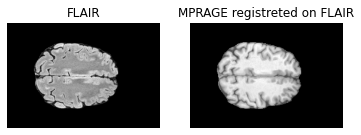

In [17]:
# Illustration of the brains skull stripped and registred

FLAIR = nib.load(bids_dir+'/derivatives/transformations/sub-'+subject+'/ses-01/sub-'+subject+'_ses-01_FLAIR_brain.nii.gz')
FLAIR = FLAIR.get_fdata()
MPRAGE_REG = nib.load(bids_dir+'/derivatives/transformations/sub-'+subject+'/ses-01/sub-'+subject+'_ses-01_MPRAGE_brain.nii.gz')
MPRAGE_REG = MPRAGE_REG.get_fdata()

fig = plt.figure()

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(FLAIR[:,:,170], cmap=plt.cm.gray)
plt.title('FLAIR')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(MPRAGE_REG[:,:,170], cmap=plt.cm.gray)
plt.title('MPRAGE registered on FLAIR')


## 5. Segment grey matter (GM) and white matter (WM)

For the moment, we have the brains (without the skull) of the MPRAGE and FLAIR and both are registered.
The final goal is to segment lesions in white matter only (lesions in gray matter are more challenging to detect). Therefore, once we get our skull stripped MPRAGE and FLAIR images, we segment the white and gray matter on the MPRAGE (WM and GM easily visible) using Otsu.

In [14]:
# Make the grey matter-white matter segmentation
make_gm_wm_mask(bids_dir, subject)
print("[INFO] Done : MPRAGE is segmented into 2 class, stored in 'derivatives/segmentations' folder of BIDS structure")

[INFO] Done : MPRAGE is segmented into 2 class, stored in 'derivatives/segmentations' folder of BIDS structure


Text(0.5, 1.0, 'WM-GM segmented on MPRAGE')

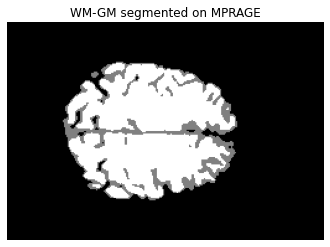

In [18]:
# Illustration of the MPRAGE segmentation

MPRAGE_seg = nib.load(bids_dir+'/derivatives/segmentations/sub-'+subject+'/ses-01/sub-'+subject+'_ses-01_gm_wm.nii.gz')
MPRAGE_seg = MPRAGE_seg.get_fdata()
fig = plt.figure()
plt.axis('off')
plt.imshow(MPRAGE_seg[:,:,170], cmap=plt.cm.gray)
plt.title('WM-GM segmented on MPRAGE')

## 6. Make the lesion mask

The goal of this step is to Match histogram with reference image (or not) : 
 - Pick (or not) an intensity and a range for lesions. 
 - Apply median filter to smooth the mask and remove too small lesions
 - Exclude lesions whose center of mass in located in the gray matter


In [19]:
# Compute lesion mask without histogram matching to a reference image(not advised)
compute_lesion_mask(bids_dir, subject, intensity=260, range_down=40, range_up=40)

# Compute lesion mask with histogram matching to a reference image : 
# histogram_matching(bids_dir, subject)
# compute_lesion_mask(bids_dir, subject, intensity=1300 , range_down=150, range_up=350, matched=True)

Lesion 1/85: (37, 95, 120)> discarded (val = 500.0)
Lesion 2/85: (58, 100, 135)> retained
Lesion 3/85: (58, 111, 134)> retained
Lesion 4/85: (59, 100, 129)> retained
Lesion 5/85: (59, 138, 144)> retained
Lesion 6/85: (60, 104, 126)> retained
Lesion 7/85: (60, 116, 136)> retained
Lesion 8/85: (62, 102, 127)> retained
Lesion 9/85: (63, 115, 137)> retained
Lesion 10/85: (62, 137, 142)> retained
Lesion 11/85: (64, 80, 161)> retained
Lesion 12/85: (65, 75, 151)> retained
Lesion 13/85: (64, 122, 132)> retained
Lesion 14/85: (64, 136, 135)> retained
Lesion 15/85: (66, 86, 143)> discarded (val = 500.0)
Lesion 16/85: (66, 121, 140)> retained
Lesion 17/85: (69, 134, 136)> retained
Lesion 18/85: (68, 120, 134)> retained
Lesion 19/85: (69, 92, 148)> retained
Lesion 20/85: (70, 103, 128)> retained
Lesion 21/85: (71, 88, 147)> discarded (val = 500.0)
Lesion 22/85: (70, 118, 138)> retained
Lesion 23/85: (71, 93, 149)> retained
Lesion 24/85: (73, 169, 149)> retained
Lesion 25/85: (74, 106, 102)> retai

Text(0.5, 1.0, 'Lesion mask')

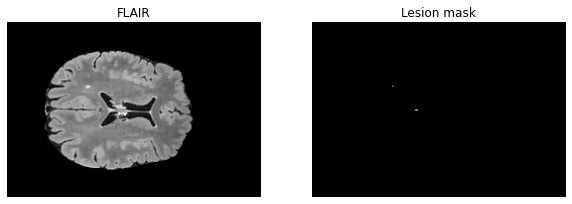

In [26]:
# Illustration of the Lesion segmentation found

FLAIR = nib.load(bids_dir+'/derivatives/transformations/sub-'+subject+'/ses-01/sub-'+subject+'_ses-01_FLAIR_brain.nii.gz')
FLAIR = FLAIR.get_fdata()
lesions = nib.load(bids_dir+'/derivatives/segmentations/sub-'+subject+'/ses-01/sub-'+subject+'_ses-01_lesion-mask.nii.gz')
lesions = lesions.get_fdata()

fig = plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(FLAIR[:,:,158], cmap=plt.cm.gray)
plt.title('FLAIR')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(lesions[:,:,158], cmap=plt.cm.gray)
plt.title('Lesion mask')
plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(FLAIR[:,:,163], cmap=plt.cm.gray)
plt.title('FLAIR')
plt.subplot(2,2,2)
plt.axis('off')
plt.imshow(lesions[:,:,163], cmap=plt.cm.gray)
plt.title('Lesion mask')

## 7. Region growing (TODO)

Finally, we can apply region growing on each lesion's 'center of mass' 

+Show result ! 

## 8. Comparison with OTSU method

## 9. Comparison with EM method
